In [1]:
!pip install pymysql

     -------------------------------------- 43.8/43.8 kB 714.6 kB/s eta 0:00:00


In [3]:
!pip install plotly

     --------------------------------------- 15.2/15.2 MB 21.1 MB/s eta 0:00:00


In [29]:
import pandas as pd
import numpy as np
import math
import pymysql
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import SelectKBest
from sklearn.svm import SVC
from umap import UMAP
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn import metrics

### Connecting Python to MySQL 

In [2]:
dbcon = pymysql.connect(host="localhost", user="root", password="root", database="breast_cancer_db")

In [3]:
dbcon

### Loading data from MySQL

In [4]:
df = pd.read_sql_query("""select * from breast_cancer""", dbcon, parse_dates = True)

In [5]:
df.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

#### Statistics of the numeric variables

Filtered all the numeric variables other than id variable in order to get the statistics and to plot the histograms for each predictor variable.

In [7]:
df1 = df.select_dtypes(include=['float64'])
df1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
radius_mean,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
texture_mean,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
perimeter_mean,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
area_mean,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
smoothness_mean,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
compactness_mean,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
concavity_mean,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
concave points_mean,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
symmetry_mean,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
fractal_dimension_mean,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


By filtering only the numeric predictors, the describe() is used to get the statistics of the data. The count in statistics show that all the variables have 569 rows of data, which is the same number of rows in the overall dataset. This shows that we have no null values in the data. Some of the variables almost have same values for mean and standard deviation like perimeter_se, area_se and concavity_se but a large difference in its minimum and maximum (spread), this could be due to the skewed distribution and the presence of outliers. Due to the presence of outliers, both mean and standard deviation are affected. By comparing the mean and median, we can get an idea of the distribution of data present in these variables. Since median is not in the descriptive statistics, it can be seen by plotting the histogram for each variables.   
#### Distribution of Features

Most of the predictor variables have right skewed and some are bimodal. Some of these have non-Gaussian distribution like radius_mean, texture_mean, perimeter_mean and area_mean.

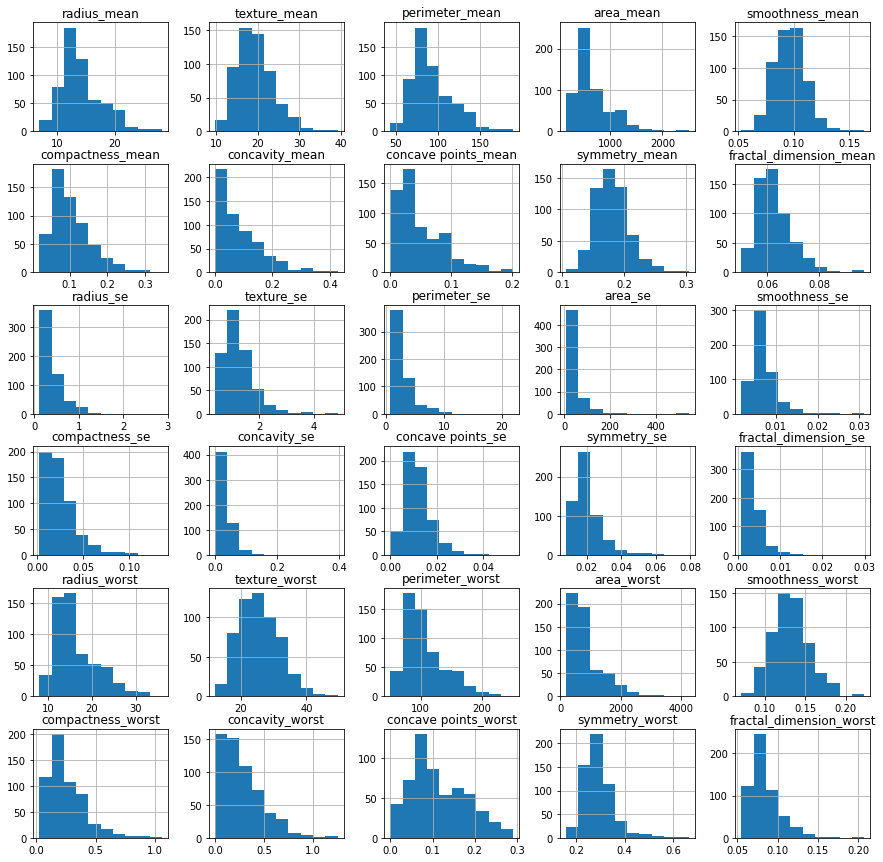

In [8]:
df1.hist(figsize=(15,15));
plt.show()

In [18]:
# sns.pairplot(df, hue="diagnosis")

#### Distribution in the outcome variable

In [10]:
df.diagnosis.value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

#### The same can be done using SQL query

In [11]:
pd.read_sql_query("""select diagnosis, count(*) from breast_cancer group by diagnosis""", dbcon, parse_dates=True)

,diagnosis,count(*)
0,M,212
1,B,357


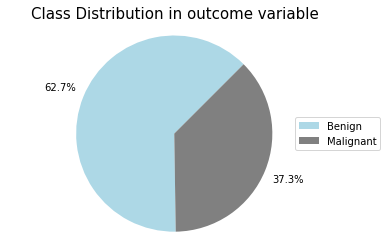

In [30]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Benign', 'Malignant'
sizes = [357, 212]
colors = ['lightblue','gray'] 

fig3, ax = plt.subplots()
ax.pie(sizes, startangle=45, autopct='%1.1f%%', colors=colors, pctdistance=1.25)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#ax.legend(labels = 'audio', 'genre', 'main', 'tasteprofile')
plt.title('Class Distribution in outcome variable', fontsize = 15)
plt.legend(labels, bbox_to_anchor=(1,0.5), loc="center right", bbox_transform=plt.gcf().transFigure)
fig3.savefig("directorysize.png", bbox_inches="tight")
plt.show()


In the pie chart, 62.7% of the data is benign and 37.3% is malignant. There is a class imbalance problem in the dataset. The classifier models when trained with this type of class imbalance, they learn only on the Benign state rather than Malignant state. To avoid this class imbalance, oversampling, downsampling or hybrid sampling should be used to balance the data.


<AxesSubplot:xlabel='area_mean', ylabel='Density'>

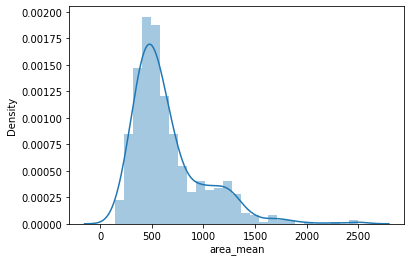

In [31]:
sns.distplot(df["area_mean"])

#### Dropping the id variable
Since Sk_Learn dont have any preprocessing step to remove like in CARET (R), id variable need to be dropped manually.

In [33]:
breastCancer_df= df.drop(columns=['id'])

## To check for null values

To visualise the missing information, install **missingno** package and import it.
In the plot, we can see that there are no missing values in the dataset.

<AxesSubplot:>

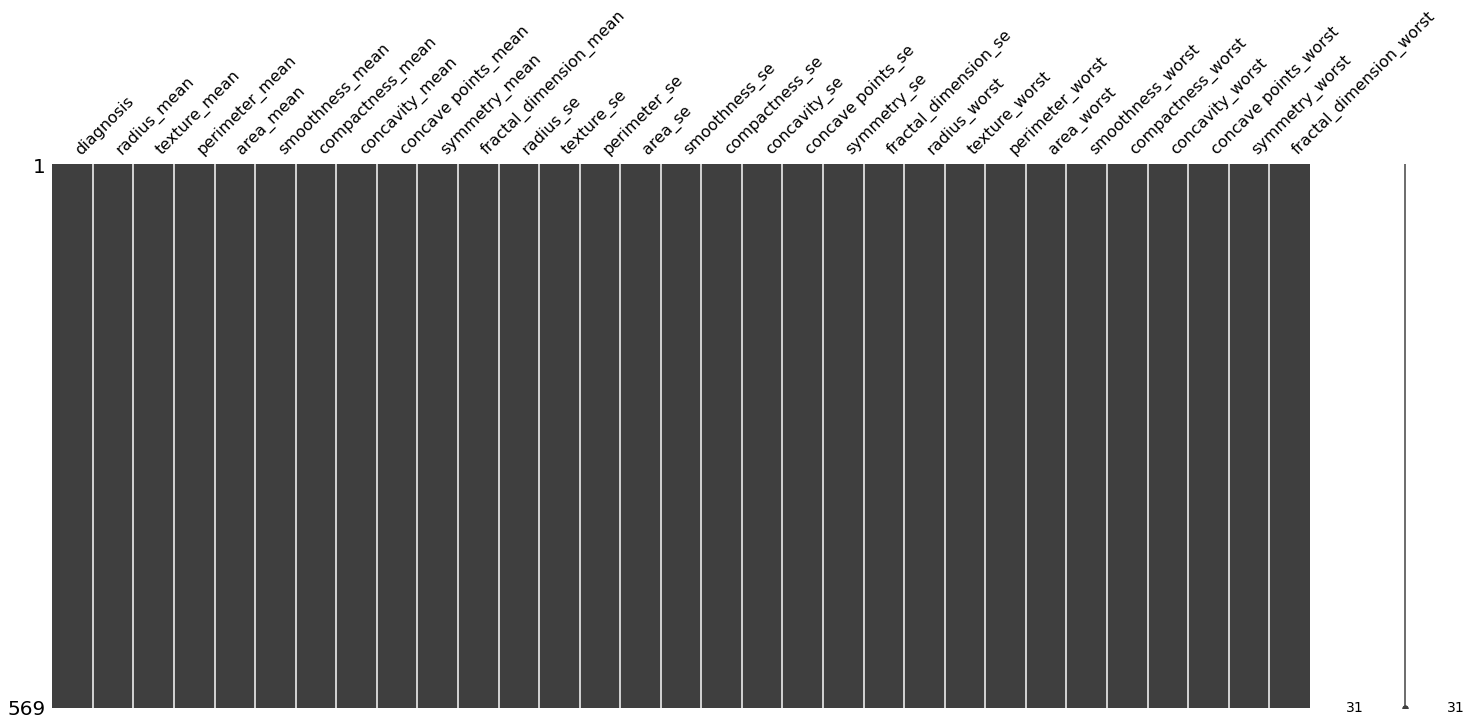

In [34]:
#!pip install missingno
import missingno as msno
msno.matrix(breastCancer_df)

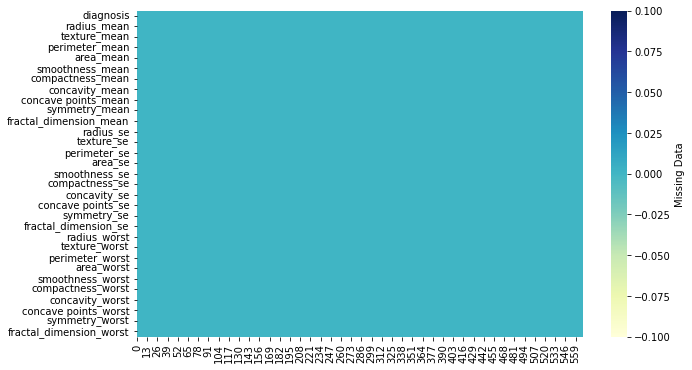

In [35]:
plt.figure(figsize=(10,6))
sns.heatmap(breastCancer_df.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.savefig("visualizing_missing_data_with_heatmap_Seaborn_Python.png", dpi=100)

#### Correlation between the predictor variables

In corr() function, **Pearson** method is used to determine if there are any correlations between the numeric variables. Since we have some groups in the plot with dark blue in colour, all these variables represent to be highly correlated. This leads to multcollinearity problem. To overcome this, PCA transformation can be applied.

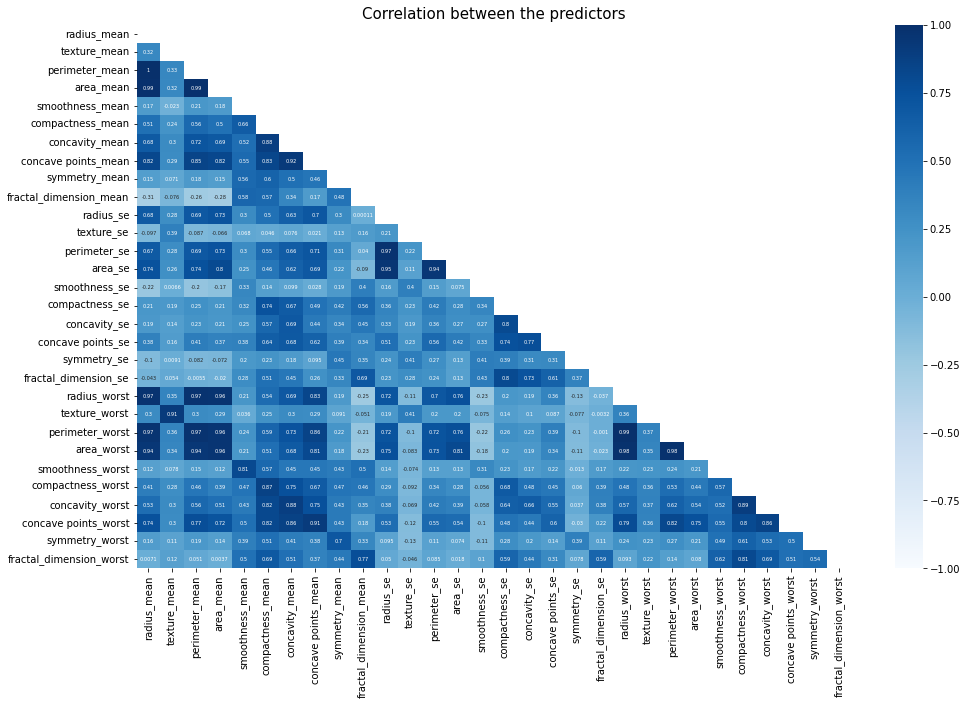

In [36]:
plt.figure(figsize=(16,10))
corrData =  breastCancer_df.corr(method='pearson')
mask = np.triu(np.ones_like(corrData, dtype=np.bool_))
sns.heatmap(corrData, cmap="Blues", annot=True, vmax=1, vmin=-1, center=0, mask= mask, annot_kws={"fontsize":5})

plt.title('Correlation between the predictors', fontsize = 15) # title with fontsize 20
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

corr = plt.gcf()
corr.savefig("correlations.jpeg", dpi=100, bbox_inches="tight")
plt.show()
plt.close()

#### Splitting the dataset into predictor values and outcome values.

Splitting the Breast cancer dataset into the numeric variables, which are predictors in X and the categorical variable diagnosis in y.

In [37]:
X = breastCancer_df.iloc[:,1:].values

The outcome variable y have only two set of values, either M (Malignant) or B (Benign). Hence, we will use ** Classification algorithm of supervised learning.**

In [38]:
y = breastCancer_df.iloc[:, :1].values

In [39]:
y

array([['M'],
       ['M'],
       ['M'],
       ['M'],
       ['M'],
       ['M'],
       ['M'],
       ['M'],
       ['M'],
       ['M'],
       ['M'],
       ['M'],
       ['M'],
       ['M'],
       ['M'],
       ['M'],
       ['M'],
       ['M'],
       ['M'],
       ['B'],
       ['B'],
       ['B'],
       ['M'],
       ['M'],
       ['M'],
       ['M'],
       ['M'],
       ['M'],
       ['M'],
       ['M'],
       ['M'],
       ['M'],
       ['M'],
       ['M'],
       ['M'],
       ['M'],
       ['M'],
       ['B'],
       ['M'],
       ['M'],
       ['M'],
       ['M'],
       ['M'],
       ['M'],
       ['M'],
       ['M'],
       ['B'],
       ['M'],
       ['B'],
       ['B'],
       ['B'],
       ['B'],
       ['B'],
       ['M'],
       ['M'],
       ['B'],
       ['M'],
       ['M'],
       ['B'],
       ['B'],
       ['B'],
       ['B'],
       ['M'],
       ['B'],
       ['M'],
       ['M'],
       ['B'],
       ['B'],
       ['B'],
       ['B'],
       ['M'],
      

#### Converting the outcome variable to binary

Since it has low cardinality and nominal categorical variable, LabelEncoder() from Sk.Learn preprocessing is used to convert the diagnosis variable into numeric form.


In [40]:
# Split the dataset into a training set and test set
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

In [41]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,

#### Train and test split

The dataset is split into train and test subsets. The 70/30 split has 70% training and 30% testing from the overall data. Stratified sampling is a technique used to split the dataset into train and test based on the outcome variable. By doing this kind of sampling, the samples are selected in the same proportion as they are in the main dataset. This is done with SK-Learn library using the train_test_split method. The random_state parameter works same as seed in R, which is set to 11 to reproduce the same values in future. 

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=11)

#### Pipeline

imbpipeline framework is created with the following pipeline steps 
* Borderline SMOTE is used for upsampling the minority class that is malignant M.

* Normalise is used for normalising the numeric predictors. Since some of the numeric predictors have non-Gaussian distribution, these has to be normalised. It takes an array as an input and normalises its values between 0 and 1. The output is in array form with same dimensions as that of input. By doing so, the features are more consistent with each other, which allows the model to predict outputs more accurately.  

* UMAP is used for dimensionality reduction. It is a nonlinear dimensionality reduction method. The hyper-parameter n_components allows to set a value for the number of dimension reduction. 

* SVM with radial basis function is used as a classification method. The hyper-parameter C is used to tune kernel = rbf, which is used for non-linear hyper-plane and C is the penalty parameter of the error term; it helps to classify the training points correctly. SVM performs well in higher dimension. 

* Tuning the hyper-parameters of an estimator like C in case of SVM rbf and n_components in case of UMAP. Since the hyper-parameters are parameters that are not directly learnt within estimators. In SciKit-learn, these are passed as arguments to the constructor of the estimator classes. By using the grid search approach to hyper-parameter tuning, it builds and evaluate a model for each combination of algorithm parameters specified in a grid and returns the best parameters.

* GridSearchCV helps to combine an estimator with a grid search preamble to tune hyper-parameters. Grid search and cv are added in order to avoid overfitting.

In [43]:
svm = SVC(kernel="rbf")

#### Train the method

In [44]:
pipeline = imbpipeline(steps = [['smote', BorderlineSMOTE(random_state=11)],
                                ['scaler', Normalizer()],
                                ['umap', UMAP()],#(n_components = 5)],
                                ['classifier', svm]])

stratified_kfold = StratifiedKFold(n_splits=10,
                                       shuffle=True,
                                       random_state=11)
    
param_grid = {'umap__n_components': [5, 10, 15, 20],
              'classifier__C':[0.001, 0.01, 0.1, 1, 10]
              }
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print(f'Best parameters:{grid_search.best_params_}')
print(f'Best parameters: {grid_search.best_estimator_}')

Cross-validation score: 0.9515238095238094
Test score: 0.9515186915887851
Best parameters:{'classifier__C': 0.001, 'umap__n_components': 15}
Best parameters: Pipeline(steps=[('smote', BorderlineSMOTE(random_state=11)),
                ('scaler', Normalizer()),
                ('umap',
                 UMAP(n_components=15, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})),
                ['classifier', SVC(C=0.001)]])



* Using the GridSearchCV(), the parameters n_components: [5, 10, 15, 20] for UMAP and C:[0.001, 0.01, 0.1, 1, 10] for SVM rbf is set. The best parameters for penalty parameter C is at 0.001 and for number of dimension reduction parameter n_components is best at 15.

GridSearchCV() is used to find the best parameter rather than manually setting a value as done in R notebook.

#### Model testing

In [45]:
y_predict = grid_search.predict(X_test)

#### Evaluation metrics

Accuracy: 86.54970760233918 %
Miss classification rate: 13.450292397660817 %
              precision    recall  f1-score   support

           0       0.97      0.81      0.88       107
           1       0.75      0.95      0.84        64

    accuracy                           0.87       171
   macro avg       0.86      0.88      0.86       171
weighted avg       0.89      0.87      0.87       171



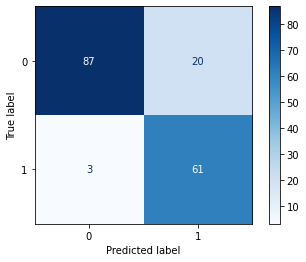

In [46]:
cm = confusion_matrix(y_test, y_predict, labels=grid_search.classes_)
print("Accuracy:",accuracy_score(y_test, y_predict)*100,"%")
print("Miss classification rate:", 100-accuracy_score(y_test, y_predict)*100,"%")
print(classification_report(y_test, y_predict))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)
#disp.plot()

disp.plot(cmap=plt.cm.Blues)
plt.show()                             

The classifier has predicted 171 predictions, which means that 171 patients were being tested for the presence of tumor. Out of 171 patients, the classifier predicted 61 times as Malignant and 87 times as Benign. Whereas in reality, 64 patients are Malignant and 107 patients are Benign. 86.55% the classifier has classified accurately and only 11.7% there was an error in predicting.
The best parameters C = 0.001 and n_components = 15

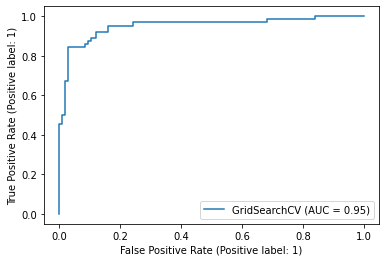

In [47]:
metrics.plot_roc_curve(grid_search, X_test, y_test) 
plt.show() 

In [48]:
from pprint import pprint
pprint(grid_search)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=11, shuffle=True),
             estimator=Pipeline(steps=[['smote',
                                        BorderlineSMOTE(random_state=11)],
                                       ['scaler', Normalizer()],
                                       ['umap', UMAP()],
                                       ['classifier', SVC()]]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 10],
                         'umap__n_components': [5, 10, 15, 20]},
             scoring='roc_auc')
